# Introduction

In this work autoencoder artificial neural network arcitecture is applied for data compression, namely for image compression.

Autoencoders are a type of neural network architecture used in unsupervised learning tasks to learn efficient representations of input data. An autoencoder consists of two functions: encoder that transforms the input data into latent space and decoder that reconstructs the original data from latent representation. An efficient latent space representation is learned from data using some reconstruction loss function with optional regularization conditions. In the context of compression latent space is a compact (compressed) representation of input data. It can be stored or transmitted and further decoded (decompressed) by reader or receiver respectively.
 
<center><img src="img/ae.png" alt="Description of the image" width="400" height="250"></center>

By using autoencoders one can achieve either lossy or lossless compression. 

Lossless compresssion means that the original data can be perfectly reconstructed from the compressed form without any loss of information. Usually dimension of latent space is chosen to be nearly equal to or greater than the input dimension to ensure exact reconstruction. During training reconstruction loss is used (e.g. MSE, BCE, etc.) that forces the autoencoder model to work nearly as identity function. Lossless models are useful in applications where loss of information is not tolerable, like singal processing, archival storage and others.

Lossy autoencoders, on the other hand, permit some loss of information in favor of data compression, so the latent space dimension is choosen to be considerably less than dimension of original data. So, during training autoencoder learns compressed representation of input data minimizing reconstruction loss function, yet some loss of fidelity in decoded data is acceptable. Lossy compression is widely used for multimedia data like images, audio, video, etc.

This work combines the description of the experiment and the listing of the program, accompanied by plots and illustrations. Lossy and lossless neural network autoencoders are described, autoencoders are compared to simple SVD compression.

# Experiments

In [1]:
# imports

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from lossy_autoencoder import LossyAutoencoder
from lossless_autoencoder import LosslessAutoencoder
from image_dataset import ImageDataset
from trainer import train
from utils import (
    plot_dataset, plot_augmentation, plot_learning_curve, 
    plot_data_latent_decoded, plot_data_decoded_svd
)
from pca_visualization import pca_visualization

from torchinfo import summary
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import v2

In [2]:
# fix seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42);

In [3]:
# choose gpu if it's available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device}')

device = cuda


For experiments simple MNIST dataset is selected. It consists of black-and-white 28x28 images with handwritten numbers from 0 to 9. The input image has 784 pixels with 8bit color depth. Therefore, each image has a size of 6272 bits. If we assume that original images have float32 datatype (they are transformed in this way during preprocessing), their sizes will be equal to 25088 bits. The float32 variant will be used in all calculations below (compression ratio for int8 will be 4 times lower that for float32).

The dataset has labels describing the numbers depicted in the images. Labels are used for classification tasks, but in this work they're use only for image captions. However, in autoencoder-based compression labels can be incorporated into the latent space to serve as additional information for the decoder at the decompression stage (conditional autoencoder idea). 

In [4]:
# load train and test dataset
MNIST_train = datasets.MNIST(
    './mnist', train=True, download=True, 
    transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
)
MNIST_test = datasets.MNIST(
    './mnist', train=False, download=True,
    transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
)
print(f"Train set size: {len(MNIST_train.targets)}\nTest set size: {len(MNIST_test.targets)}")

# fit the data into [0; 1] range
X_train = MNIST_train.data / MNIST_train.data.max()
X_test = MNIST_test.data / MNIST_train.data.max()

Train set size: 60000
Test set size: 10000


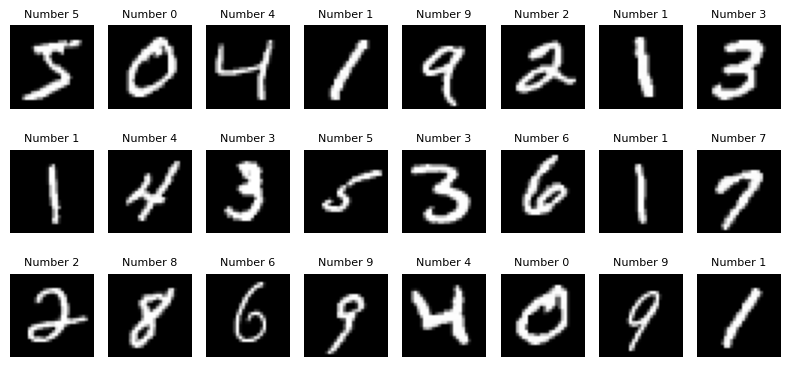

In [5]:
plot_dataset(MNIST_train)

## Lossy autoencoder model

The dataset under consideration consists of images, so it's reasonable to choose convolutional architecture for decoder and encoder. Encoder includes 2D convolutions and 2D average poolings, for activation function trainable parametric ReLU (PReLU) is chosen. As it's lossy autoencoder, latent space dimension is smaller than data dimension and equals to 32. Latent space is vector of 32 32-bit floats, so its size is 1024 bit. The expected compression ratio is $28\cdot 28/32 = 24.5$. Decoder is made up of 2D transposed convolutions with PReLU activations between them. The last layer is sigmoid function, its purpose is to map the output signal into the range of [0; 1]

In [32]:
lossy_autoencoder = LossyAutoencoder()
print(summary(lossy_autoencoder))

Layer (type:depth-idx)                   Param #
LossyAutoencoder                         --
├─LossyEncoder: 1-1                      --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  640
│    │    └─PReLU: 3-2                   64
│    │    └─AvgPool2d: 3-3               --
│    │    └─Conv2d: 3-4                  73,856
│    │    └─PReLU: 3-5                   128
│    │    └─AvgPool2d: 3-6               --
│    │    └─Conv2d: 3-7                  73,792
│    │    └─PReLU: 3-8                   64
│    │    └─AvgPool2d: 3-9               --
│    │    └─Conv2d: 3-10                 2,080
│    │    └─PReLU: 3-11                  32
├─LossyDecoder: 1-2                      --
│    └─Sequential: 2-2                   --
│    │    └─ConvTranspose2d: 3-12        9,248
│    │    └─PReLU: 3-13                  32
│    │    └─ConvTranspose2d: 3-14        25,632
│    │    └─PReLU: 3-15                  32
│    │    └─ConvTranspose2d: 3-16        25,104
│  

In [7]:
X_tmp_encode = lossy_autoencoder.encode(X_train[0].reshape(1, 1, 28, 28))
print(f'latent space size: {X_tmp_encode.shape[1]}')

latent space size: 32


## Lossless autoencoder model

For Lossless autoencoder different model is selected. For a change, it has only fully-connected layers and PReLU activations. The penultimate layer in decoder is reshaping layer (to make a 2D image from a vector), the last layer is sigmoid as in lossy model. In this case there is no storage savings. Praсtical usefulness of this model is doubtful, but ok for comparison between lossy model.

In [31]:
lossless_autoencoder = LosslessAutoencoder()
print(summary(lossless_autoencoder))

Layer (type:depth-idx)                   Param #
LosslessAutoencoder                      --
├─LosslessEncoder: 1-1                   --
│    └─Sequential: 2-1                   --
│    │    └─Flatten: 3-1                 --
│    │    └─Linear: 3-2                  615,440
│    │    └─PReLU: 3-3                   784
│    │    └─Linear: 3-4                  615,440
│    │    └─PReLU: 3-5                   784
├─LosslessDecoder: 1-2                   --
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-6                  615,440
│    │    └─PReLU: 3-7                   784
│    │    └─Linear: 3-8                  615,440
│    │    └─PReLU: 3-9                   784
│    │    └─Unflatten: 3-10              --
│    │    └─Sigmoid: 3-11                --
Total params: 2,464,896
Trainable params: 2,464,896
Non-trainable params: 0


## Training

Both models are trained with MSE reconstruction loss using Adam optimizer. As a regularization during training l2 weight decay with small coefficient (1e-9) is applied. For better learning results on limited dataset, for better generalization ability, the data augmentation described below is used.

In [23]:
lr = 1e-3         # learning rate 
gamma = 0.98      # exponential lr decay multiplier
batch_size = 100  # batch size of images
num_epochs = 300  # total number of epochs

In [10]:
# Training data augmentation:
# 1) random rotation in range [-15; 15] deg
# 2) random translation along x and y axis in range [-0.1; 0.1] * 28 pixels
# 3) random image scaling with ratio in range [0.9; 1.1]
# 4) random shear parallel to x axis, range [-10, 10] deg
# For these transforms bilinear interpolation is used

train_transforms = v2.Compose([
    v2.RandomAffine(
        degrees=15,
        translate=(0.1, 0.1), 
        scale=(0.9, 1.1), 
        shear=10, 
        interpolation=v2.InterpolationMode.BILINEAR
    )
])

train_dataset = ImageDataset(X_train.unsqueeze(1), transform=train_transforms)
test_dataser = ImageDataset(X_test.unsqueeze(1))

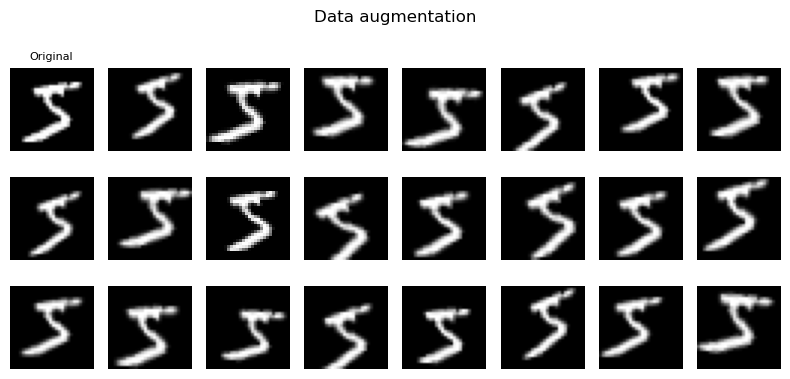

In [11]:
plot_augmentation(X_train[0], train_transforms)

In [12]:
# augmentation before learning, dataset is increased aug_coef times

aug_coef = 5

old_num = X_train.shape[0]
X_augmented = torch.zeros((old_num * aug_coef, 1, *X_train.shape[1:]))
X_augmented[:old_num, 0] = X_train
for i in range(1, aug_coef):
    X_augmented[old_num*i:old_num*(i+1), 0] = train_transforms(X_train)

In [13]:
# define datasets for dataloaders
train_dataset = ImageDataset(X_augmented, transform=None)
test_dataser = ImageDataset(X_test.unsqueeze(1))

In [14]:
# define dataloaders, train dataset is shuffled in each epoch
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_dataser,
    batch_size=batch_size,
    shuffle=False
)

Note: weight_decay for Adam - l2-like regularization

In [15]:
optimizer = torch.optim.Adam(params=lossless_autoencoder.parameters(), lr=lr, weight_decay=1e-9)
loss_function = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)

In [ ]:
loss_logs_lossy = train(
    model=lossy_autoencoder,
    loss_function=loss_function,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    num_epochs=num_epochs,
    device=device
)

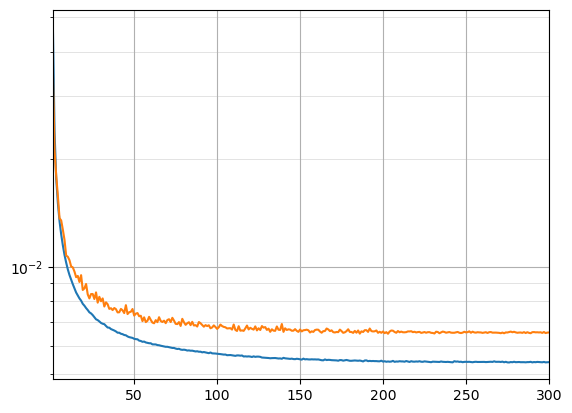

In [28]:
plot_learning_curve(loss_logs_lossy, num_epochs, semilogy=True)

In [ ]:
loss_logs_lossless = train(
    model=lossless_autoencoder,
    loss_function=loss_function,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    num_epochs=num_epochs,
    device=device
)

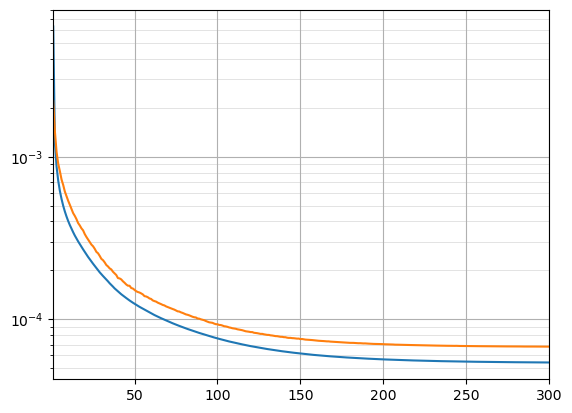

In [30]:
plot_learning_curve(loss_logs_lossless, num_epochs, semilogy=True)

As it can be seen from learning curves, both models are converged to some minima. Reconstruction loss for lossless autoencoder is expectedly lower than for lossy model. The reconstrunction quality and latent space visualization are given in the next section.

## Visualization

For both lossy and lossless models we plot figures with triples of images: original image - latent space (compressed image) - reconstructed image (decompressed image).

As one could see, lossy autoencoder reconstructs images fairly good: all numbers are clearly identified (as long as original image is legible), writing style features are preserved, however, some small details (like small side strokes, hooks) are not reproduced, image is also slightly blurry. Nevertheless, for such high compression ratio (24.5) the result is quite good. 

Lossless model can be named nearly-lossless, because MSE loss is low, but nonzero, alhough visually changes are negligible.

As for visualization purpose, both latent spaces are mapped to 2D space using PCA.

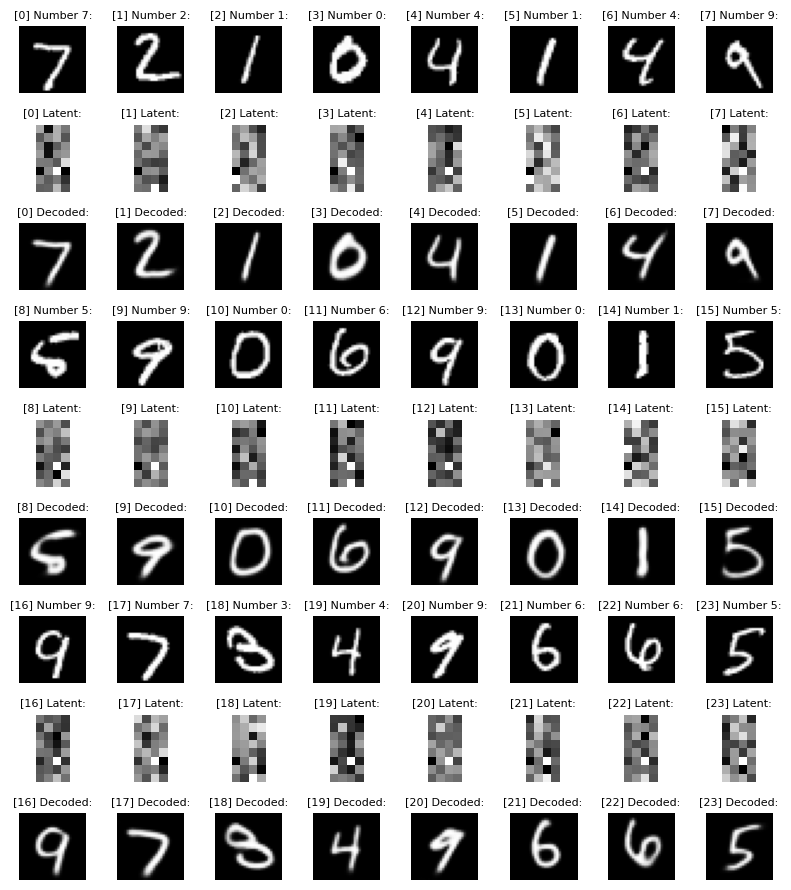

In [49]:
plot_data_latent_decoded(lossy_autoencoder, X_test, MNIST_test.targets, device, lossless=False)

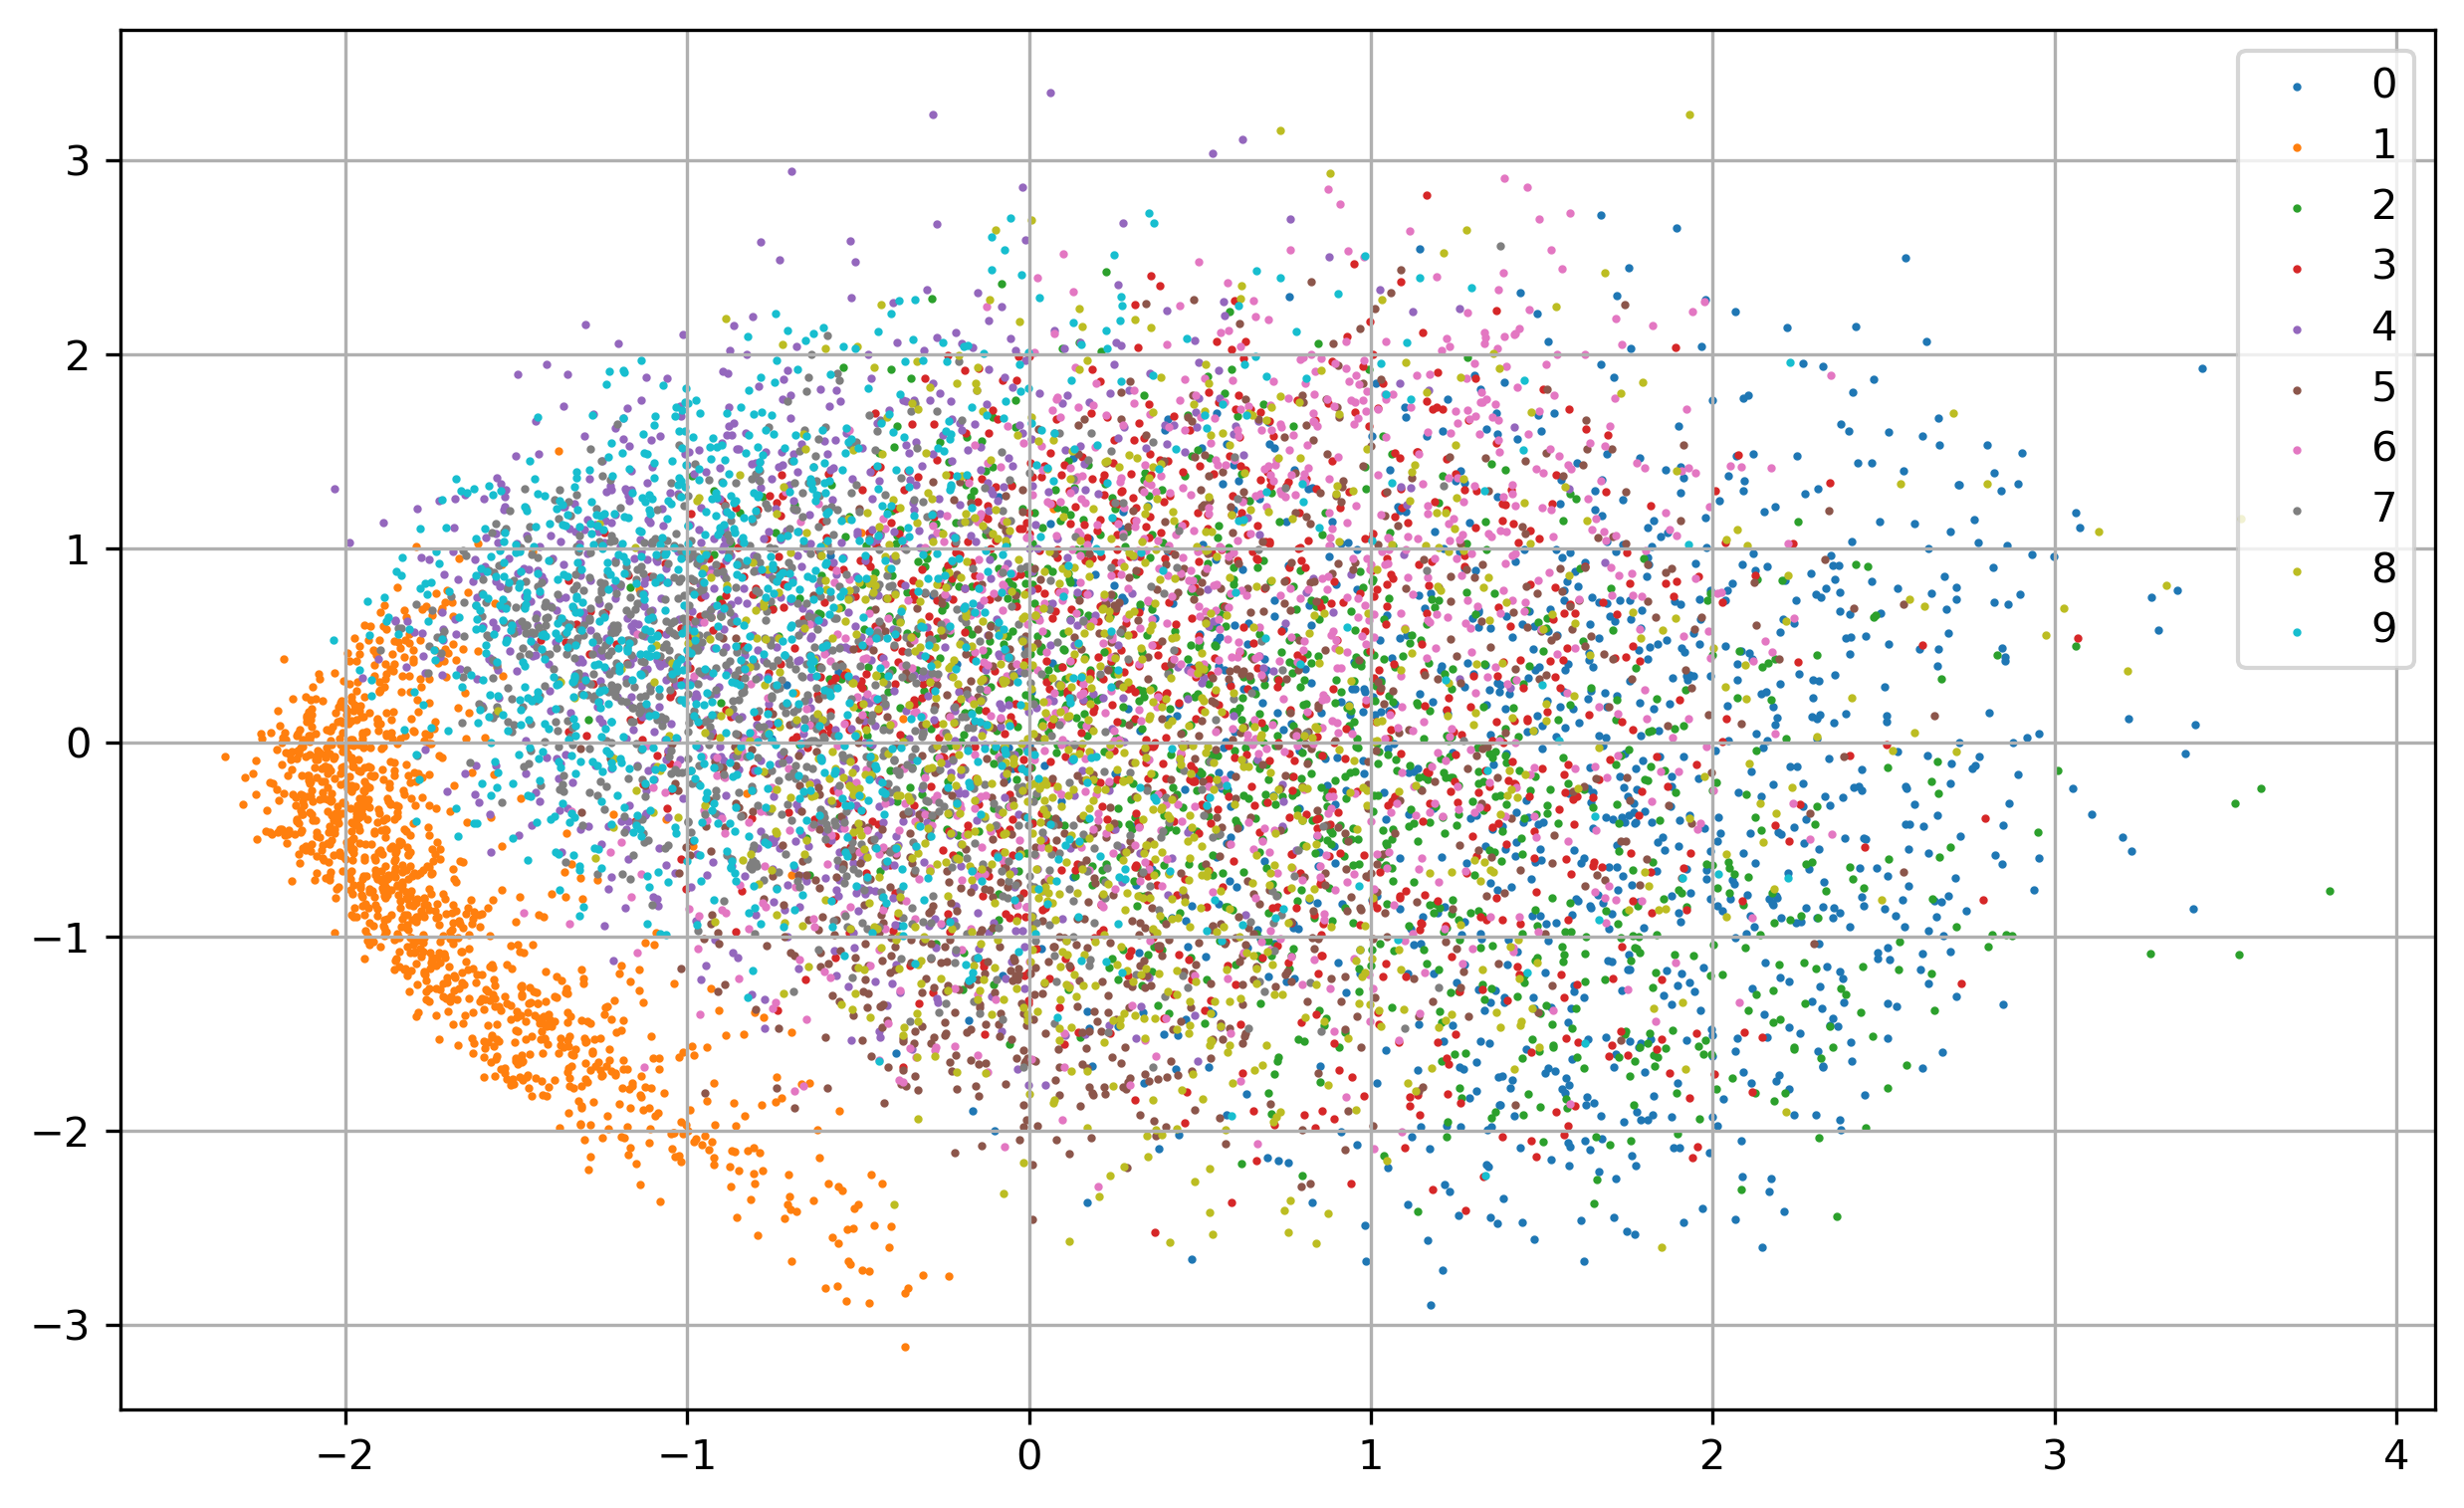

In [50]:
X_train_latent = np.concatenate(
    [lossy_autoencoder.encode(X_train[1000*i:1000*(i+1)].unsqueeze(1).to(device), flatten=False)
     .squeeze().detach().cpu().flatten(1).numpy() for i in range(60)]
)
X_test_latent = np.concatenate(
    [lossy_autoencoder.encode(X_test[1000*i:1000*(i+1)].unsqueeze(1).to(device), flatten=False)
     .squeeze().detach().cpu().flatten(1).numpy() for i in range(10)]
)

pca_visualization(X_train_latent, X_test_latent, MNIST_test.test_labels)

In [51]:
lossless_autoencoder.load_state_dict(torch.load('lossless_fc_784_aug.pth'))

<All keys matched successfully>

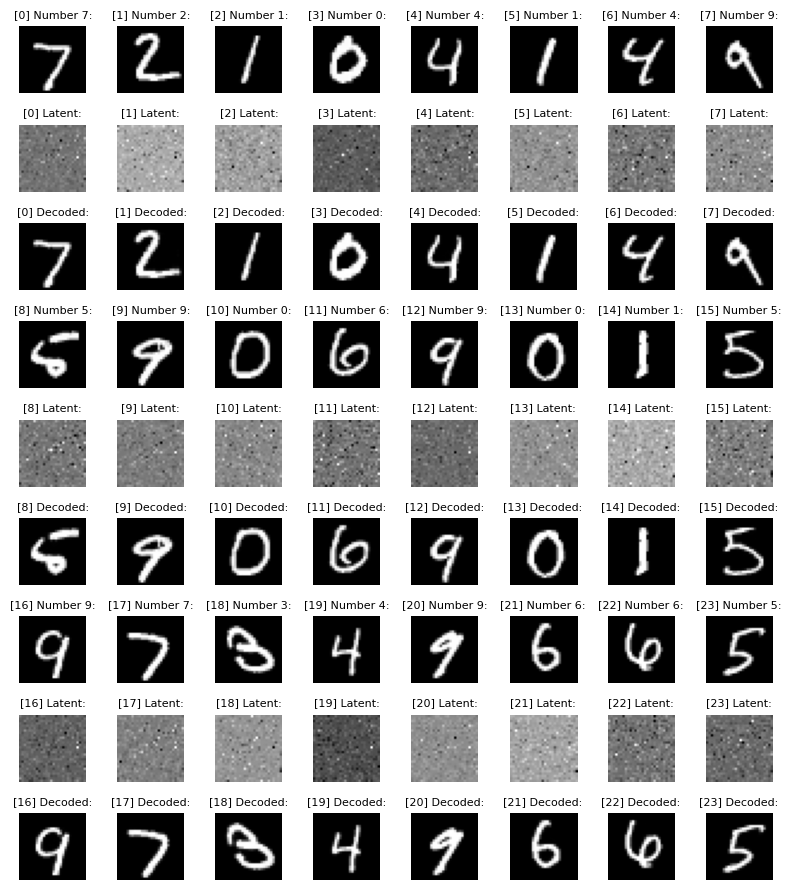

In [60]:
plot_data_latent_decoded(lossless_autoencoder, X_test, MNIST_test.targets, device)

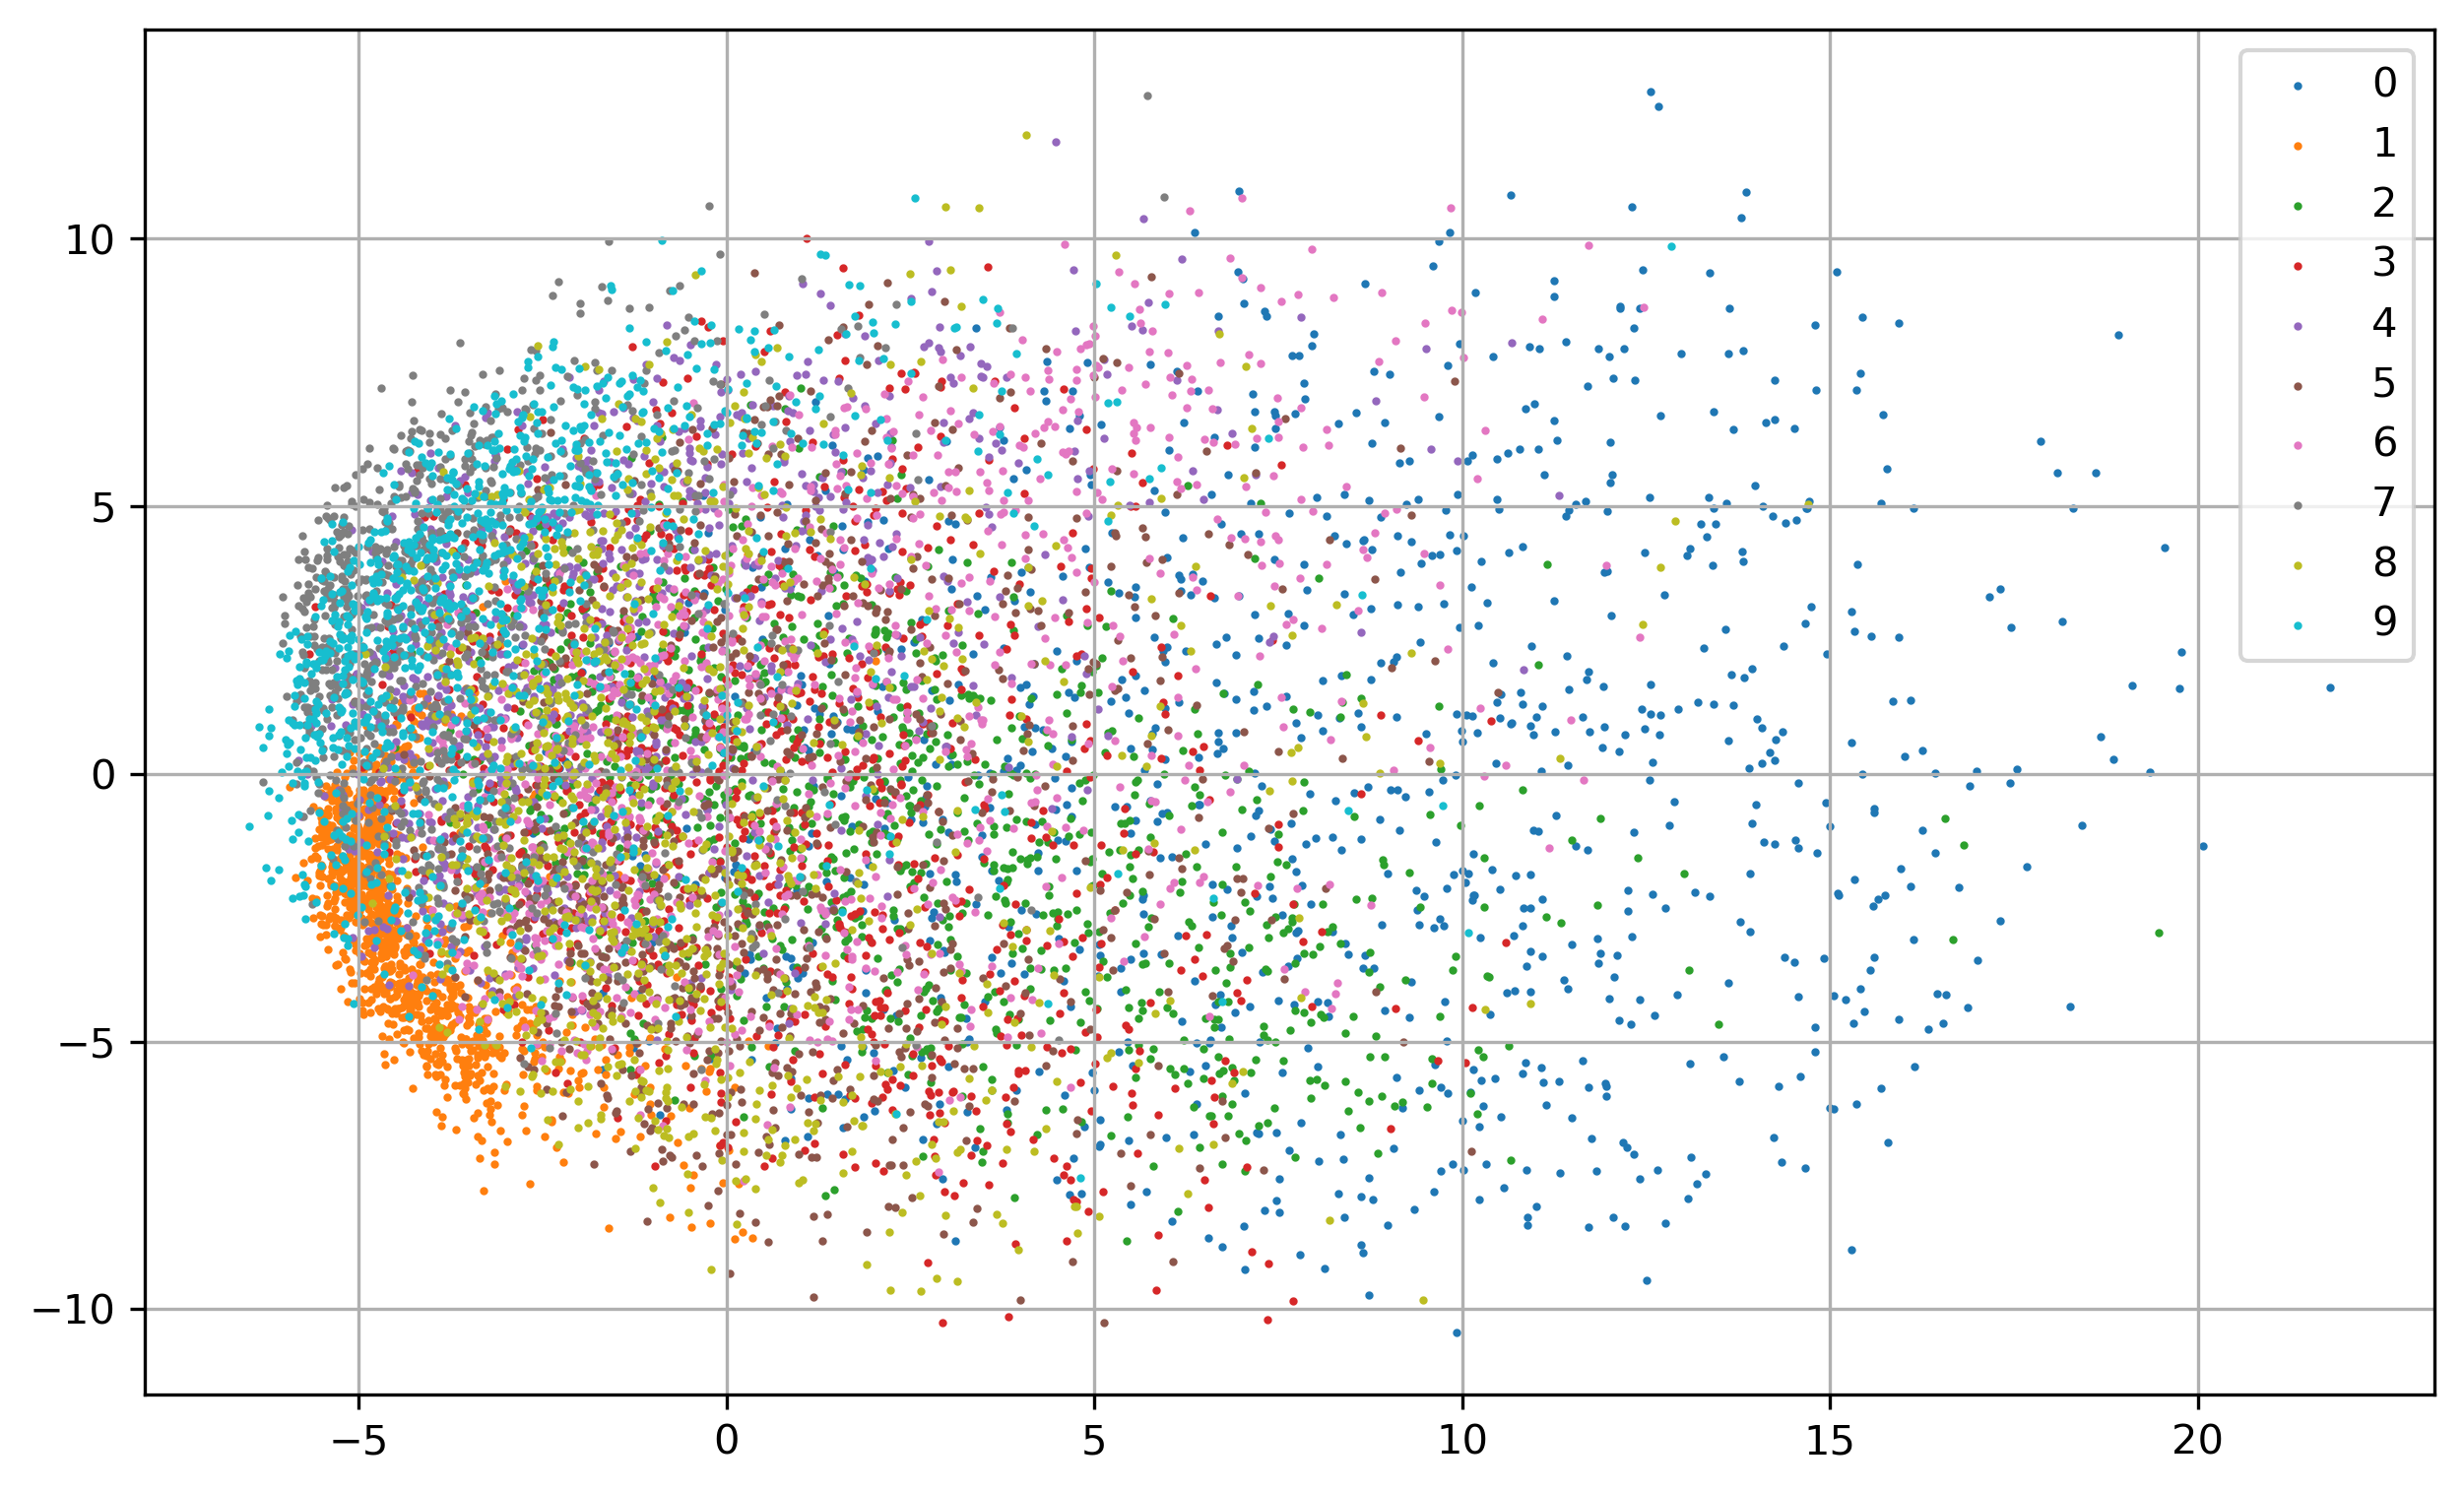

In [63]:
X_train_latent = lossless_autoencoder.encode(X_train.to(device), flatten=False).squeeze().detach().cpu().numpy()
X_test_latent = lossless_autoencoder.encode(X_test.to(device), flatten=False).squeeze().detach().cpu().numpy()

pca_visualization(X_train_latent, X_test_latent, MNIST_test.test_labels)

## SVD compression

Let's compare autoencoder-based compression with simple classical approach - SVD compression. Here we choose the number $r$ of biggest singular values to set others to null. Using corresponding left and right singular vectors one can reconstruct the initial image. The quality of reconstrunction depends on $r$, i.e. on the rank of the transform. In accordance with Eckart–Young theorem, the given reconstruction is the best the among linear approximations for l2 and frobenius norms (effectively, our MSE loss is frobenius norm or redisue). We find $r$, such that MSE is close to autoencoder-based models, then visually compare the results.

As one can see, for lossy autoencoder rank is approximately equals to 5, for lossless - to 13. For ranks 19 and more the transform is really close to lossless. 

For lossy compression and SVD compression results are interesting: although MSE loss is almost identical, the kinds of decompression distortions are different. In lossy autoencoder we get slightly blurry images with absense of some fine details, but in SVD image block structure is very noticable, however some fine details are more visible, yet with additional artifacts. One could say that perceptually lossy autoencoder did a better work. Moreover, SVD-based model requires 28r + 28r + r = 57r = 285 floats, whereas autoencoder needs only 32.

Comparison with lossless autoencoder does not make sense: both models visually looks like lossless.

In [15]:
U, S, V = torch.linalg.svd(X_train.to(device))

svd_mse = []
for r in range(0, S.shape[1]+1):
    Sr = S.clone()
    Sr[:, r:] = 0
    X_train_svd_rec = torch.einsum('bij,bj,bjk->bik', U, Sr, V)
    svd_mse.append(F.mse_loss(X_train_svd_rec, X_train.to(device)).item())

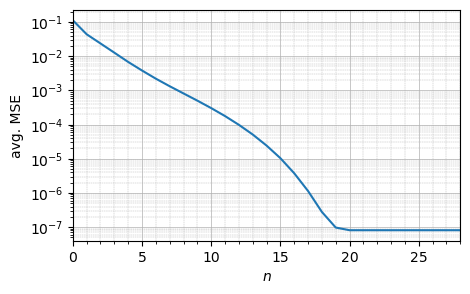

In [19]:
plt.figure(figsize=(5, 3))
plt.semilogy(range(0, S.shape[1]+1), svd_mse)
plt.xlim([0,  S.shape[1]])
plt.grid(True, which='major', lw=0.5); plt.grid(True, which='minor', lw=0.3, ls='--'); plt.minorticks_on()
plt.xlabel('$n$'); plt.ylabel('avg. MSE')
plt.show()

In [6]:
r_svd_lossy_like = 5

U, S, V = torch.linalg.svd(X_test.to(device))
S[:, r_svd_lossy_like:] = 0
X_test_svd_rec_lossy_like = torch.einsum('bij,bj,bjk->bik', U, S, V)

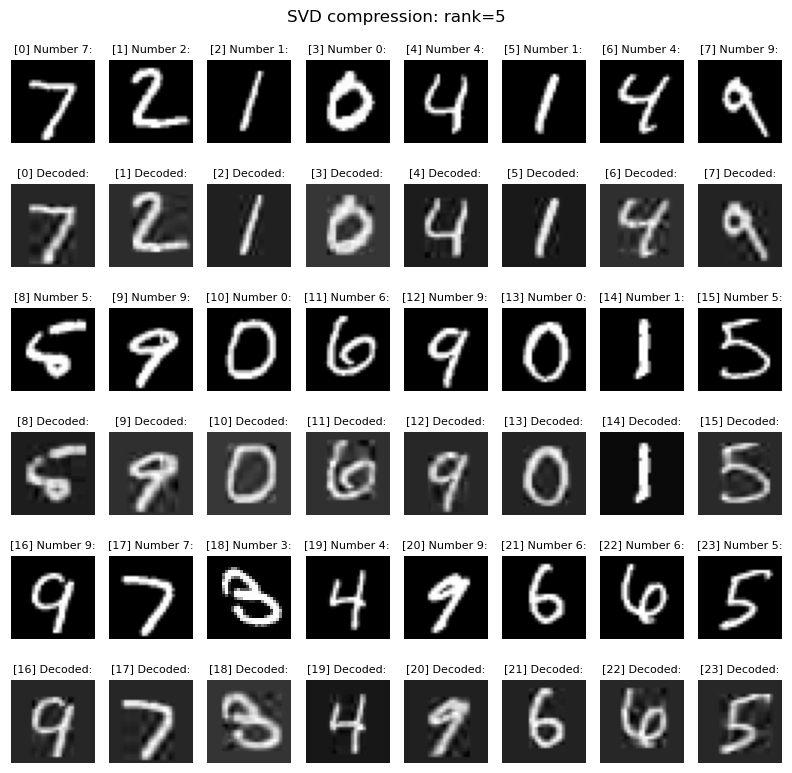

In [8]:
plot_data_decoded_svd(X_test, X_test_svd_rec_lossy_like, MNIST_test.test_labels, r_svd_lossy_like)

In [9]:
r_svd_lossless_like = 13

U, S, V = torch.linalg.svd(X_test.to(device))
S[:, r_svd_lossless_like:] = 0
X_test_svd_rec_lossless_like = torch.einsum('bij,bj,bjk->bik', U, S, V)

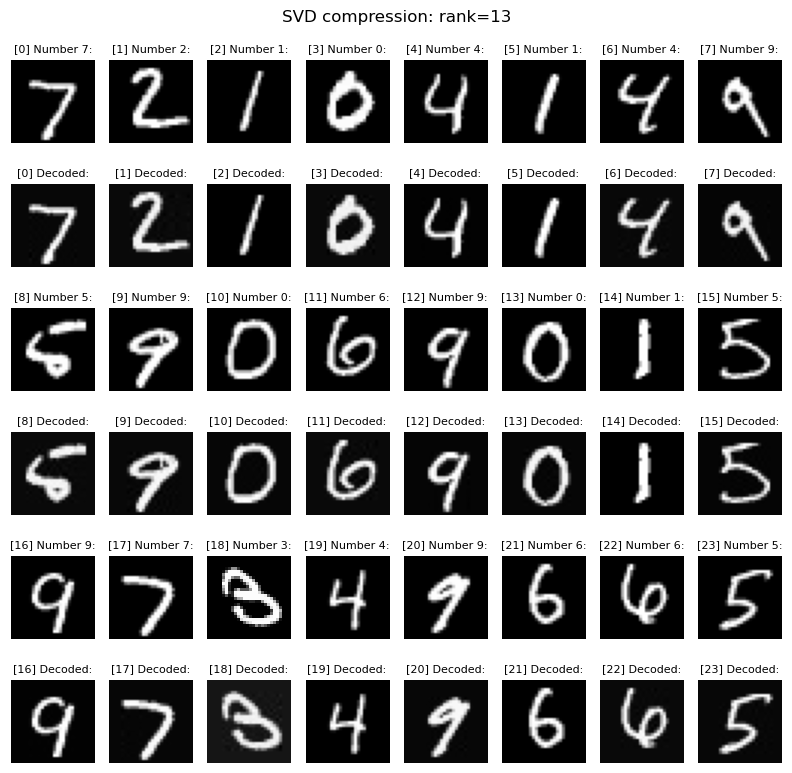

In [13]:
plot_data_decoded_svd(X_test, X_test_svd_rec_lossless_like, MNIST_test.test_labels, r_svd_lossless_like)

# Concluson

In this work the application of autoencoders for image compression is studied. Both lossy and (nearly-)lossless models of different architectures are built, trained and tested, these nonlinear neural network-based models are compared to linear SVD-based model. Nearly-lossless model nearly perfectly reconstructs the image, but without any storage benifits. Lossy model allows to achieve high compression ratio with acceptable fidelity.